# Deep learning homework 3 
## Weather forecast with neural network
## Author: Mate Jakab (YMCNE9)
## Created at 26-10-2020

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)


Text(0, 0.5, 'Tmin&Tmax')

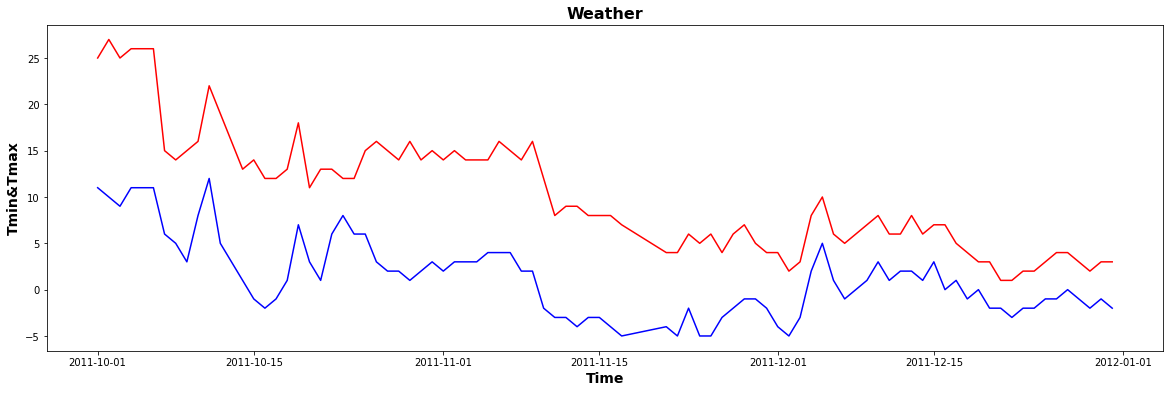

In [17]:
import pandas as pd
from datetime import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

np.random.seed(1998)
tf.random.set_seed(1210)

# Data import from csv (Source: http://idojarasbudapest.hu/archivalt-idojaras)
df_raw = pd.read_csv("weather_forecast_data.csv")

df_raw['Year'] = pd.DatetimeIndex(df_raw['Date']).year
df_raw['Month'] = pd.DatetimeIndex(df_raw['Date']).month
df_raw['DayOfYear'] = pd.DatetimeIndex(df_raw['Date']).dayofyear
df_raw['Day'] = pd.DatetimeIndex(df_raw['Date']).day
df_raw['Week'] = pd.DatetimeIndex(df_raw['Date']).week

# Nonnegative Id -> archived data
df = df_raw[ df_raw['Id'] > 0]

# Use only the datas from October to December (2011-2020)
df = df[ (df['Month'] >= 10) & (df['Month'] <= 12) ]
df = df.sort_values(by="Date")
df['Date'] = pd.to_datetime(df.Date) 

# Plot data (max temperature = red, min temperature = blue)
plt.figure(figsize=(20, 6))
plt.plot(df[df['Year'] < 2012]['Date'], df[df['Year'] < 2012]['Tmax'], color='r')
plt.plot(df[df['Year'] < 2012]['Date'], df[df['Year'] < 2012]['Tmin'], color='b')
plt.title('Weather', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Tmin&Tmax', weight='bold', fontsize=14)

In [18]:
# Splitting input and output data into train, validation and test datasets
def dataset_split(X, Y, valid_split, test_split):
    v_start = int(len(Y)*(1-valid_split-test_split))
    t_start = int(len(Y)*(1-test_split))
    X_train, Y_train = X[:v_start], Y[:v_start]
    X_valid, Y_valid = X[v_start:t_start], Y[v_start:t_start]
    X_test , Y_test  = X[t_start:], Y[t_start:]
    return X_train, Y_train, X_valid, Y_valid, X_test, Y_test

In [19]:
pd.to_datetime(df.pop('Date'), format = '%Y.%m.%d')

df = df.sample(frac=1).reset_index(drop=True)

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

# Tmin_1 value of i. day equals the minimum temperature value of the (i-1).day 
X_train, Y_train, X_valid, Y_valid, X_test, Y_test = dataset_split(df[['Year', 'DayOfYear', 'Tmin']], df[['Tmin', 'Tmax']].values, 0.15, 0.05)
#X_train, Y_train, X_valid, Y_valid, X_test, Y_test = dataset_split(df[['Year', 'DayOfYear', 'Tmin_1']], df['Tmin'].values.reshape(-1,1), 0.1, 0.1)

# Scaler objects for input and output data
scaler = preprocessing.StandardScaler().fit(X_train)
scalery = preprocessing.StandardScaler().fit(Y_train)

X_train = scaler.transform(X_train)
X_valid= scaler.transform(X_valid)
X_test = scaler.transform(X_test)
Y_train = scalery.transform(Y_train)
Y_valid= scalery.transform(Y_valid)
Y_test = scalery.transform(Y_test)

print(X_train.shape)
print(Y_train.shape)

(680, 3)
(680, 2)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import Callback, TensorBoard
from tensorflow.keras.optimizers import SGD, RMSprop
from keras import regularizers

def create_model():
    model = Sequential()

    # Shape from X_train.shape
    model.add(Dense(10, input_shape=(X_train.shape[1],))) 

    model.add(Activation("tanh"))
    model.add(Dense(64))
    model.add(Activation("tanh"))
    model.add(Dense(64))
    model.add(Activation("tanh"))
    # Shape from Y_train.shape
    model.add(Dense(Y_train.shape[1]))

    # Last activation function is linear (did not work with tanh)
    model.add(Activation("linear"))

    model.compile( loss='mean_squared_logarithmic_error',
                    optimizer ='adam'
                  )
    return model

In [22]:
# Class for storing training history
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = [] 
        self.valid_accs = []
        self.epoch = 0
    
    # Save model information after every epoch
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1

In [23]:
# Function for decreasing learning rate automatically
from keras.callbacks import ReduceLROnPlateau
# Early stopping (with val_loss values)
from keras.callbacks import EarlyStopping
# Monitor val_loss and save the best model
from keras.callbacks import ModelCheckpoint

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=10e-6)
early_stopping=EarlyStopping(patience=5, min_delta=10e-5, verbose=0) 
checkpointer=ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=0)   
history = TrainingHistory()
        
#logdir = "logs/scalars/" + datetime.now().strftime("%H%M%S") + "_"
#tb = TensorBoard(log_dir=logdir, histogram_freq=1)
#tensorboard_callback = TensorBoard(log_dir=logdir, write_graph=True, histogram_freq=1)

In [24]:
model = create_model()
model.fit(X_train, Y_train,
          batch_size=32,
          epochs=2000,
          verbose=2, 
          validation_data=(X_valid,Y_valid),
          # Callback metrics
          callbacks=[reduce_lr, checkpointer, early_stopping, history])

Epoch 1/2000
22/22 - 0s - loss: 0.0677 - val_loss: 0.0244
Epoch 2/2000
22/22 - 0s - loss: 0.0172 - val_loss: 0.0143
Epoch 3/2000
22/22 - 0s - loss: 0.0147 - val_loss: 0.0131
Epoch 4/2000
22/22 - 0s - loss: 0.0140 - val_loss: 0.0130
Epoch 5/2000
22/22 - 0s - loss: 0.0136 - val_loss: 0.0123
Epoch 6/2000
22/22 - 0s - loss: 0.0136 - val_loss: 0.0122
Epoch 7/2000
22/22 - 0s - loss: 0.0136 - val_loss: 0.0124
Epoch 8/2000
22/22 - 0s - loss: 0.0133 - val_loss: 0.0118
Epoch 9/2000
22/22 - 0s - loss: 0.0129 - val_loss: 0.0119
Epoch 10/2000
22/22 - 0s - loss: 0.0130 - val_loss: 0.0122
Epoch 11/2000
22/22 - 0s - loss: 0.0133 - val_loss: 0.0126
Epoch 12/2000
22/22 - 0s - loss: 0.0128 - val_loss: 0.0118
Epoch 13/2000
22/22 - 0s - loss: 0.0128 - val_loss: 0.0118


Text(0, 0.5, 'Tmin and Tmax (predicted and correct values)')

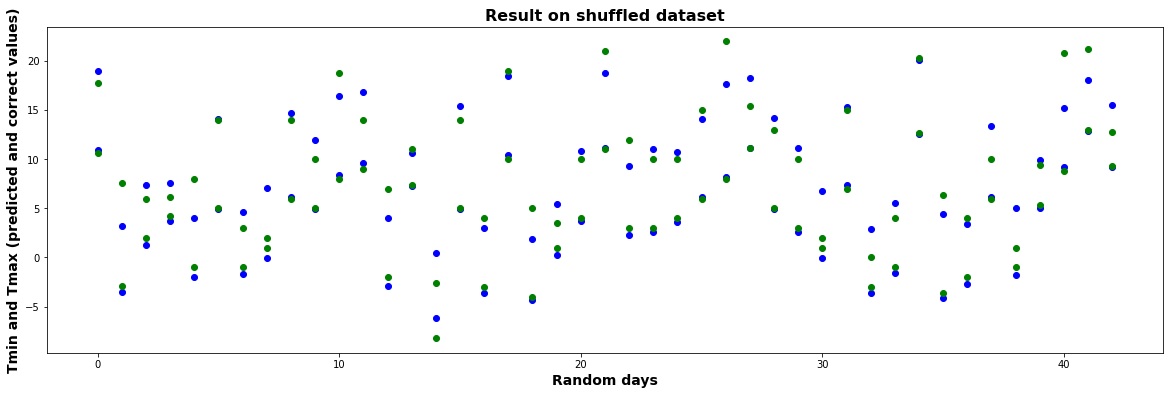

In [25]:
# predicted values of X_test (Tmin and Tmax)
Y1 =  scalery.inverse_transform(model.predict(X_test))
# correct values of X_test's output (Y_test)
Y2 = scalery.inverse_transform(Y_test)
#print(Y_test)

plt.figure(figsize=(20, 6))
plt.plot(np.arange(len(Y1)), Y1, 'o', color='blue')
plt.plot(np.arange(len(Y2)), Y2, 'o', color='green')
plt.title('Result on shuffled dataset', weight='bold', fontsize=16)
plt.xlabel('Random days', weight='bold', fontsize=14)
plt.ylabel('Tmin and Tmax (predicted and correct values)', weight='bold', fontsize=14)

In [26]:
# Put data into array
# (the rows that contain future dates got negative 'Id's)
array_predict = np.asarray(df_raw[df_raw['Id'] < 0][['Year', 'DayOfYear', 'Tmin_1', 'Tmin', 'Tmax']])

# Output value starts from 'Tmin'
y_start = 3
for i in range(len(array_predict)):
    # Prediction of future dates
    lista = []
    lista.append(array_predict[i][:y_start])
    to_save = scalery.inverse_transform(model.predict(scaler.transform(lista)))

    # Save prediction to 'Tmin' and 'Tmax'
    array_predict[i][y_start:] = to_save
    
    print(array_predict[i])
    if(i+1 < len(array_predict)):
        array_predict[i+1][y_start-1] = to_save[0][0]

[2020.          300.           12.9          12.43126965   17.09003067]
[2020.          301.           12.43126965   12.05572414   16.68211555]
[2020.          302.           12.05572414   11.7427578    16.32910538]
[2020.          303.           11.7427578    11.47347641   16.01394463]
[2020.          304.           11.47347641   11.23545361   15.72567177]
[2020.          305.           11.23545361   11.02009201   15.45685482]
[2020.          306.           11.02009201   10.82119274   15.20223713]
[2020.          307.           10.82119274   10.63412094   14.95796299]
[2020.          308.           10.63412094   10.45530128   14.72111416]
[2020.          309.           10.45530128   10.28189278   14.48941803]
[2020.          310.           10.28189278   10.11157703   14.26106834]
[2020.          311.           10.11157703    9.94240665   14.03458691]
[2020.          312.            9.94240665    9.77270508   13.80874157]
[2020.          313.            9.77270508    9.60098457   13.58

In [27]:
# Save data to lists (will be shown in diagram)

# Minimum temperatures
y_futuremin = []
# Maximum temperatures
y_futuremax = []

date = []

print('Results for asked days:')

for j in range(len(array_predict)):
    # Year and dayofyear into date
    string = str(int(array_predict[j][0])) + ' ' + str(int(array_predict[j][1]))
    new_date = datetime.strptime(string, '%Y %j')
    date.append(new_date)
    min_val = array_predict[j][y_start]
    max_val = array_predict[j][y_start+1]
    y_futuremin.append(min_val)
    y_futuremax.append(max_val)
    if (str(new_date) == '2020-10-28 00:00:00') | (str(new_date) == '2020-11-03 00:00:00') | (str(new_date) == '2020-11-24 00:00:00'):
        print(new_date, ' min_value: ', min_val, ', max value: ', max_val)


Results for asked days:
2020-10-28 00:00:00  min_value:  11.742757797241211 , max value:  16.329105377197266
2020-11-03 00:00:00  min_value:  10.455301284790039 , max value:  14.721114158630371
2020-11-24 00:00:00  min_value:  5.39286470413208 , max value:  9.246733665466309


Text(0.5, 0, 'Time')

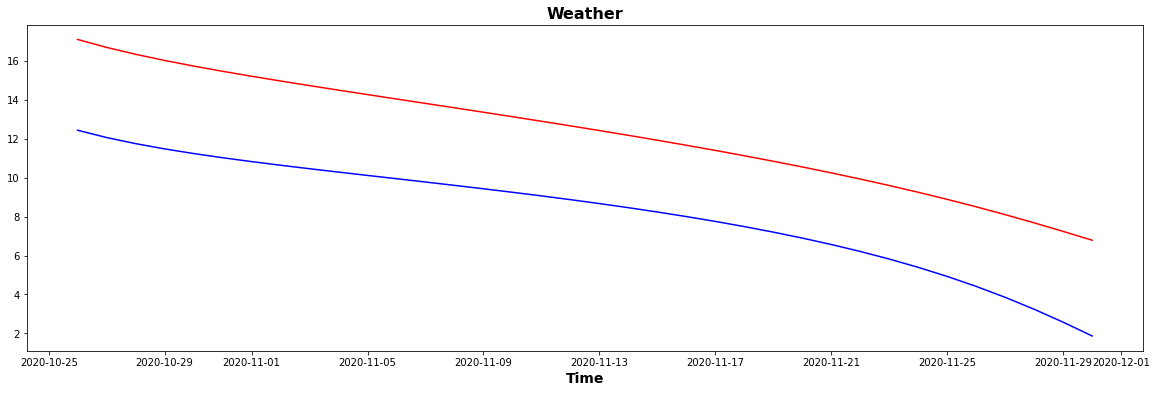

In [28]:
plt.figure(figsize=(20, 6))
plt.plot(date, y_futuremin, color='blue')
plt.plot(date, y_futuremax, color='red')
plt.title('Weather', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)